# Trilateration Using Mulitple Simulated Points With Scipy Least Squares

## Test Data Generation
The initial part of the script is to provide some test data for the trilateration algorithm. This is attempting to simulate seismic shots going to a reciever. 

The first section generates a random cloud of shots between 5 and 7 metres water depth and assigns a first break pick value with some error. 

In [1]:
#import tool set
import pandas as pd

import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import scipy
from scipy.optimize import least_squares


In [2]:
#intial and target values
Xi=5000521.0
Yi=5000512.0
Zi=-300.0
Si=1535.0 

#set the maximum number of points to be used in the least squares calculation
filter_limit=200

#set sample point parameters
x_min = 5000000
x_max = 5001000
y_min = 5000000
y_max = 5001000
z_min = -7
z_max = -5
err_min = -10
err_max = 10
sample_size = 2000


#create sample points
dataX = pd.DataFrame(np.random.randint(x_min,x_max,size=(sample_size,1)), columns=list('X'))
dataY = pd.DataFrame(np.random.randint(y_min,y_max,size=(sample_size,1)), columns=list('Y'))
dataZ = pd.DataFrame(np.random.uniform(z_min,z_max,size=(sample_size,1)), columns=list('Z'))
error = pd.DataFrame(np.random.uniform(err_min,err_max,size=(sample_size,1)), columns=list('E'))
data = pd.concat([dataX, dataY, dataZ, error], axis=1, sort=False)

#distances to intial point with error
data['fbp'] = ((((data['X']-Xi+(data['E']))**2 + (data['Y']-Yi+(data['E']))**2 + (data['Z']-Zi+(data['E']))**2)**0.5))/(Si + data['E'])


## Finding The Calculated Position
The next section calculates the point where the FBP falls by scaling.

In [3]:
#calculate the observed distance by applying the speed of sound in water
data['observed_dist']=(data['fbp']*Si)

#determine calculated ranges
data['calc_ranges']=((data['X']-Xi)**2 + (data['Y']-Yi)**2 + (data['Z']-Zi)**2)**0.5

#determine the scale; did the range over shoot or undershoot the target?
data['scale']=data['observed_dist']/data['calc_ranges']

#determine diffs from intial point to calculated point
data['diff_X']= data['X']-Xi
data['diff_Y']= data['Y']-Yi
data['diff_Z']= data['Z']-Zi

#apply the scaling
data['diff_X_scaled']= (data['X']-Xi)*data['scale']
data['diff_Y_scaled']= (data['Y']-Yi)*data['scale']
data['diff_Z_scaled']= (data['Z']-Zi)*data['scale']

#determine "landing point" of the first break by apply the scaling on the xyz coordinate
data['final_X']= data['X']-data['diff_X_scaled']
data['final_Y']= data['Y']-data['diff_Y_scaled']
data['final_Z']= data['Z']-data['diff_Z_scaled']

#determine the final difference between the intial position and the "landing point"
data['final_diff']=((data['final_X']-Xi)**2 + (data['final_Y']-Yi)**2 + (data['final_Z']-Zi)**2)**0.5

## Unfiltered Data
As can be seen the final offset from the observed FBP to the calulated point is normally distributed. This provides some opportunities for filtering and optimising the least squares attempt. 

There are also some possibilities of filtering on distance from the point based on the calculated ranges. Closer ranges should be given a higher weighting.

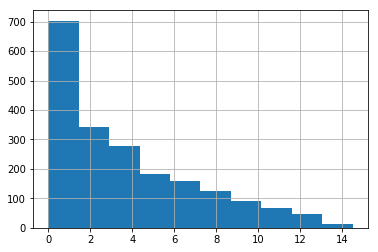

In [4]:
data['final_diff'].hist()

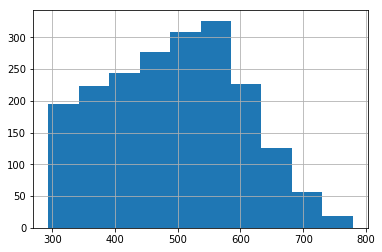

In [5]:
data['calc_ranges'].hist()

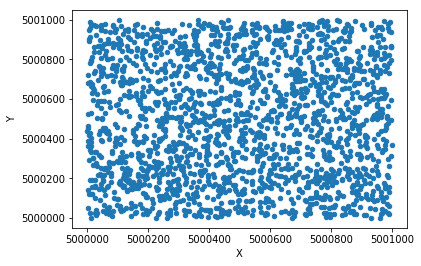

In [6]:
data.plot.scatter('X', 'Y')

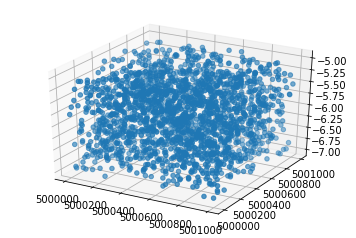

In [7]:
ax = plt.axes(projection='3d')
xdata = (data.X.tolist())
ydata = (data.Y.tolist())
zdata = (data.Z.tolist())

ax.scatter3D(xdata, ydata, zdata);

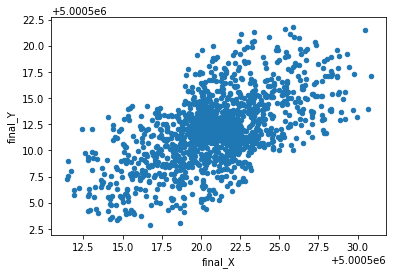

In [8]:
data.plot.scatter('final_X', 'final_Y')

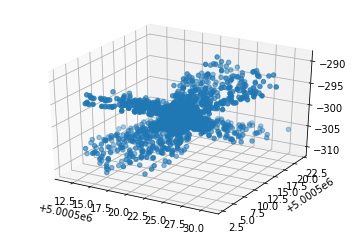

In [9]:
ax = plt.axes(projection='3d')
xdata = (data.final_X.tolist())
ydata = (data.final_Y.tolist())
zdata = (data.final_Z.tolist())

ax.scatter3D(xdata, ydata, zdata);

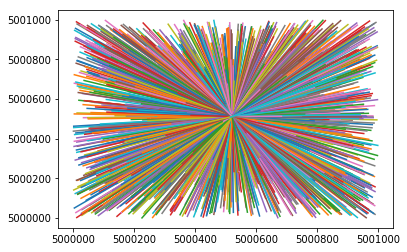

In [10]:
x0data = (data.X.tolist())
y0data = (data.Y.tolist())

x1data = (data.final_X.tolist())
y1data = (data.final_Y.tolist())

for x0,y0,x1,y1 in zip(x0data,y0data,x1data,y1data):
    plt.plot([x0,x1],[y0,y1])

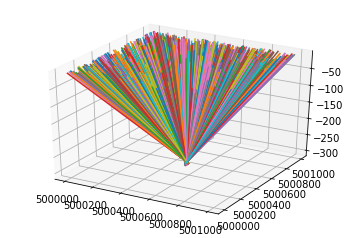

In [11]:
ax = plt.axes(projection='3d')
x0data = (data.X.tolist())
y0data = (data.Y.tolist())
z0data = (data.Z.tolist())
x1data = (data.final_X.tolist())
y1data = (data.final_Y.tolist())
z1data = (data.final_Z.tolist())

for x0,y0,z0,x1,y1,z1 in zip(x0data,y0data,z0data,x1data,y1data,z1data):
    ax.plot([x0,x1],[y0,y1],[z0,z1])

## Filtered Data
Showing the effects of filtering on the data by selecting the 200 closest inputs to the intial point. 

In [12]:
filter = data.sort_values(by=['calc_ranges'])
filter = filter.head(filter_limit)
filter = filter.astype('float64', copy=False)

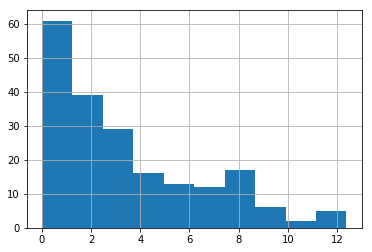

In [13]:
filter['final_diff'].hist()

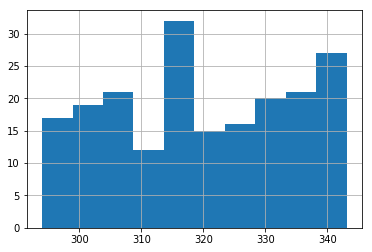

In [14]:
filter['calc_ranges'].hist()

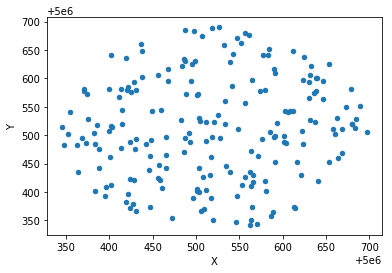

In [15]:
filter.plot.scatter('X', 'Y')

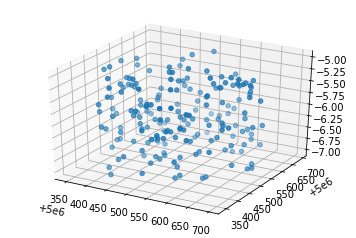

In [16]:
ax = plt.axes(projection='3d')
xdata = (filter.X.tolist())
ydata = (filter.Y.tolist())
zdata = (filter.Z.tolist())

ax.scatter3D(xdata, ydata, zdata);

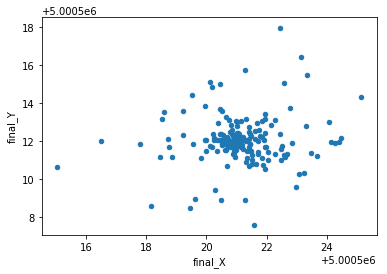

In [17]:
filter.plot.scatter('final_X', 'final_Y')

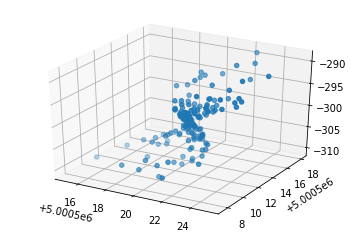

In [18]:
ax = plt.axes(projection='3d')
xdata = (filter.final_X.tolist())
ydata = (filter.final_Y.tolist())
zdata = (filter.final_Z.tolist())
ax.scatter3D(xdata, ydata, zdata);

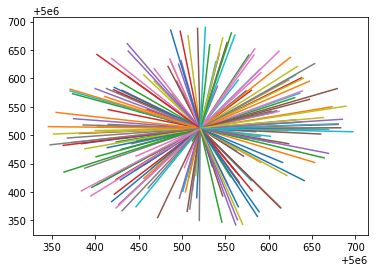

In [19]:
x0data = (filter.X.tolist())
y0data = (filter.Y.tolist())

x1data = (filter.final_X.tolist())
y1data = (filter.final_Y.tolist())

for x0,y0,x1,y1 in zip(x0data,y0data,x1data,y1data):
    plt.plot([x0,x1],[y0,y1])

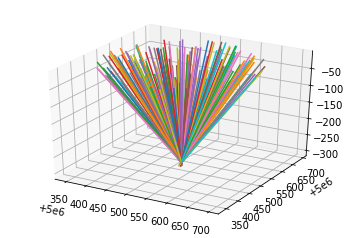

In [20]:
ax = plt.axes(projection='3d')
x0data = (filter.X.tolist())
y0data = (filter.Y.tolist())
z0data = (filter.Z.tolist())
x1data = (filter.final_X.tolist())
y1data = (filter.final_Y.tolist())
z1data = (filter.final_Z.tolist())

for x0,y0,z0,x1,y1,z1 in zip(x0data,y0data,z0data,x1data,y1data,z1data):
    ax.plot([x0,x1],[y0,y1],[z0,z1])

## Creating Least Squares Equations
Create the least squares equations based on the filtered data. This are written to equations.py and the called by the least squares calculation.

In [21]:
x_list=filter['X'].tolist()
y_list=filter['Y'].tolist()
z_list=filter['Z'].tolist()
r_list=filter['observed_dist'].tolist()

text_file = open("equations.py", "w")
print("def equations( guess):", file=text_file)
print("\tx, y, z, r = guess", file=text_file)
print("\treturn (", file=text_file)

i=0

while i < len(filter.index):
    print("\t\t(x - ",x_list[i],")**2 + (y - ",y_list[i],")**2 + (z - ",z_list[i],")**2 - (r -",r_list[i],")**2,", sep="", file=text_file)
  
    i=i+1
print("\t)",file=text_file)    
    
text_file.close()

## Run The Least Squares

In [22]:
#import the set of equations just written
from equations import equations

# make SciPy solve the system using an initial guess.
# the initial guess affects which of the "candidates" SciPy finds.
initial_guess = (Xi, Yi, Zi, 0)

results = least_squares(equations, initial_guess)

results

 active_mask: array([0., 0., 0., 0.])
        cost: 781856515.842279
         fun: array([-4.65812589e+03, -2.67525320e+03,  8.30840401e+02, -5.65557163e+03,
       -6.41474286e+03, -1.21884562e+03, -2.40405111e+03, -5.83682862e+03,
        1.21639596e+03, -2.19354603e+02,  4.86169310e+02, -5.83456859e+03,
       -1.96578607e+02, -3.20938767e+03, -5.81830697e+03,  1.41486929e+03,
       -3.03524986e+03,  5.62839727e+01,  1.49021082e+03,  2.79042765e+03,
        2.92918865e+03,  3.06638155e+03, -1.72195639e+03, -4.50170315e+03,
       -3.20943018e+03,  1.20472886e+03, -3.83169554e+03, -2.69336503e+03,
       -3.81083064e+02, -3.06652635e+03, -3.19691132e+03,  2.36372123e+03,
       -9.97242414e+02, -1.82573072e+03, -7.08494088e+03,  1.19332554e+02,
       -2.19616006e+03, -2.39263160e+03,  1.18731665e+02, -4.88061665e+03,
        1.68864739e+03, -1.67127154e+03,  1.96384072e+02, -2.12849707e+02,
       -3.59336233e+02, -7.38930121e+02, -2.46052015e+01, -6.26533316e+03,
        6.0984482

In [23]:
#covariance matrix = (J^T J)^{-1}
J = results.jac
JT = results.jac.transpose()
cov_matrix = pd.DataFrame((JT.dot(J))**-1)
cov_matrix

,0,1,2,3
0,1.520479e-07,1.710081e-06,-1.193694e-06,1.016888e-06
1,1.710081e-06,1.596506e-07,-4.155769e-06,4.563093e-06
2,-1.193694e-06,-4.155769e-06,1.769435e-08,-1.599330e-08
3,1.016888e-06,4.563093e-06,-1.599330e-08,1.441845e-08


In [24]:
cov_mat_xy = cov_matrix.drop([2,3], 1)
cov_mat_xy = cov_mat_xy.drop([2,3], 0)
cov_mat_xy

#see http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/ for expanding this section

,0,1
0,1.520479e-07,1.710081e-06
1,1.710081e-06,1.596506e-07


In [25]:
LA.eig(cov_mat_xy)

(array([-1.55423552e-06,  1.86593401e-06]), array([[-0.70789225, -0.70632043],
        [ 0.70632043, -0.70789225]]))

In [26]:
print(results.x[0]-Xi,"metres diff in x")
print(results.x[1]-Yi,"metres diff in y")
print(results.x[2]-Zi,"metres diff in z")

1.2222929000854492 metres diff in x
0.3527768151834607 metres diff in y
28.22726740243604 metres diff in z
